# Import modules

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import random

# Set Hyperparameter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(777)
if device == "cuda":
    torch.cuda.manual_seed_all(777)
print(f"using {device}")

batch_size = 100
learning_rate = 1e-3
num_epoch = 2000

using cuda


# Load Data

In [3]:
def get_alphabet(root: str, batch_size: int):
    
    train_path = os.path.join(root, 'train')
    test_path = os.path.join(root, 'test')
    
    train1_rotation = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                      transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.RandomRotation(5)
                                 ]),
                                 target_transform=None)
    
    train2_default = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1)
                                     #, transforms.CenterCrop(26), transfroms.Resize(28)
                                 ]),
                                 target_transform=None)
    
    train3_crop = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.CenterCrop(26),
                                     transforms.Resize(28)
                                 ]),
                                 target_transform=None)
    
    train4_inv = ImageFolder(root = train_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
#                                     transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
                                     transforms.Grayscale(1),
                                     transforms.RandomInvert()
                                 ]),
                                 target_transform=None)
    
    
    alphabet_test = ImageFolder(root = test_path,
                                 transform=transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Grayscale(1)
                                 ]),
                                 target_transform=None)
    
    train_loader = DataLoader(train1_rotation,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True,
                              num_workers=8)

    test_loader = DataLoader(alphabet_test,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False,
                             num_workers=8) 
    
    return (train1_rotation, train_loader, test_loader)

In [4]:
original_data, train_loader, test_loader = get_alphabet('./processed_data', batch_size)

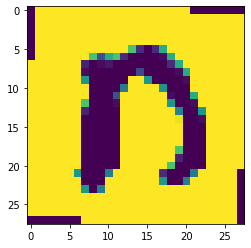

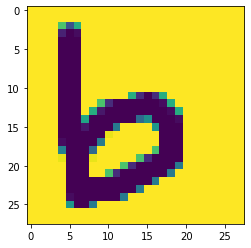

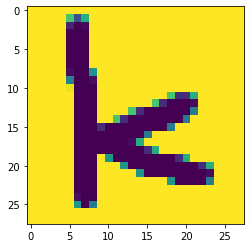

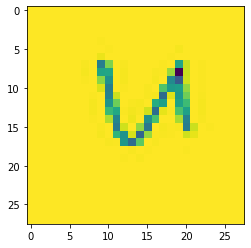

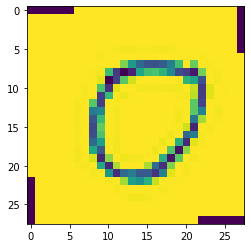

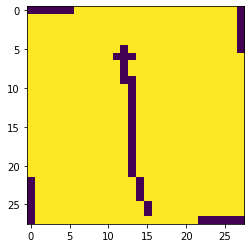

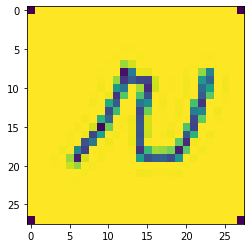

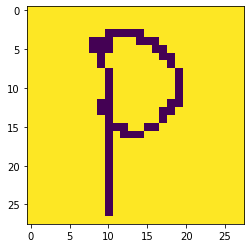

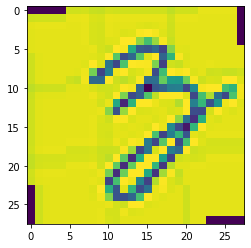

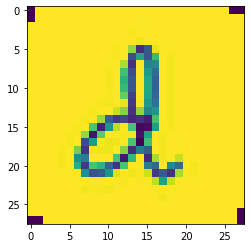

In [5]:
%matplotlib inline

def tensorToNumpy(tensor):
    c, w, h = tensor.shape
    
    img = np.zeros_like(tensor)
    img = img[0,:,:]
    img[:,:] = tensor[0,:,:]
    
    plt.figure()
    plt.imshow(img)

for i in random.choices(range(len(original_data)), k=10):
    image, target = original_data.__getitem__(i)
    tensorToNumpy(image)


# CNN Class

In [6]:
#### 
'''class CNN(nn.Module):  # train with rotated and adamw
    def __init__(self):
        a=32
        b=128
        c=512
        d=1024
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(          # 28x28      
            nn.Conv2d(a, b, 3, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(         #14x14
            nn.Conv2d(b, c, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2),
                         
            nn.Conv2d(c, d, 3, padding=1),
            nn.BatchNorm2d(d),
            nn.ReLU(inplace=True),  
            nn.MaxPool2d(kernel_size=2, stride=2, padding=1)            
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=d*4*4, out_features=1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(1024, 26)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''

'''
## rotate, dropout04, optim_adam, kernel 5, out_feature = 512 ---> 99.56
## rotate, dropout04, optim_adam, kernel 3, out_feature = 512 ---> 99.48
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(c),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 26)
        )
        
#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''
    
    
## rotate, dropout04, optim_adam, kernel all 5, out_feature = 512 ---> 99.56
## rotate, dropout04, optim_adam, kernel 3, out_feature = 512 ---> 99.48
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 5, padding=2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 5, padding=2),
            nn.BatchNorm2d(c),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(512, 26, kernel_size=5, padding=2),
            nn.BatchNorm2d(26),
            nn.AdaptiveAvgPool2d(1),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        

        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out

#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
#     def forward(self, x):
#         out = self.layer1(x) 
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = out.view(out.size(0), -1)
#         out = self.fc_layer(out)
#         return out

    
    
    
    
## 



'''class CNN(nn.Module):
    def __init__(self):
        a=32
        b=128
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, 128, 5, padding=2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True)
        )
        self.layer2 = nn.Sequential(          # 28x28      

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.layer3 = nn.Sequential(         #14x14

            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=512*4*4, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(512, 26)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(512, 26, kernel_size=5, padding=2),
            nn.BatchNorm2d(26),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
            nn.Dropout(0.4)
        )
        
        
#         self.residual_layer = nn.Sequential(
#             nn.Conv2d(1, 128, 1)
#         )
        
    def forward(self, x):
        out = self.layer1(x) 
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        return out
'''
    
'''   0.991
class CNN(nn.Module):
    def __init__(self):
        a=32
        b=64
        c=512
        
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(         # 28x28
            nn.Conv2d(1, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
        )
        self.layer2 = nn.Sequential(          # 28x28      
            nn.Conv2d(a, a, 3, padding=1),
            nn.BatchNorm2d(a),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.layer3 = nn.Sequential(         #14x14
            nn.Conv2d(a, b, 3, padding=1),
            nn.BatchNorm2d(b),
            nn.ReLU(inplace=True),  
            
            nn.Conv2d(b, b, kernel_size=3, padding=1),    #7x7
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 26)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc_layer(out)
        return out'''

'   0.991\nclass CNN(nn.Module):\n    def __init__(self):\n        a=32\n        b=64\n        c=512\n        \n        super(CNN, self).__init__()\n        self.layer1 = nn.Sequential(         # 28x28\n            nn.Conv2d(1, a, 3, padding=1),\n            nn.BatchNorm2d(a),\n            nn.ReLU(inplace=True),\n        )\n        self.layer2 = nn.Sequential(          # 28x28      \n            nn.Conv2d(a, a, 3, padding=1),\n            nn.BatchNorm2d(a),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(2,2)\n        )\n        self.layer3 = nn.Sequential(         #14x14\n            nn.Conv2d(a, b, 3, padding=1),\n            nn.BatchNorm2d(b),\n            nn.ReLU(inplace=True),  \n            \n            nn.Conv2d(b, b, kernel_size=3, padding=1),    #7x7\n            nn.BatchNorm2d(64),\n            nn.ReLU(inplace=True),\n            nn.MaxPool2d(kernel_size=2, stride=2)\n        )\n        self.fc_layer = nn.Sequential(\n            nn.Linear(in_features=64*7*7, o

# Define model

In [7]:
model = CNN().to(device)

# train1_2_ pretrained
# model = torch.load("./weights/rotate_drpout04_adamoptim_kernel5_126ep_acc99.5619888305664.pth").to(device)


loss_func = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-1)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)


# Training

In [8]:
def test_acc(model, test_loader=test_loader):
    correct = 0
    total = 0
    model = model.eval()
    with torch.no_grad():
        for image, label in test_loader:
            x = image.to(device)
            y = label.to(device)

            output = model.forward(x)
            _, output_index = torch.max(output, 1)

            total += label.size(0)
            correct += (output_index == y ).sum().float()

        return f"{100.0*correct/total}"

In [9]:
max_accuracy =0.
from tqdm import tqdm

for i in range(1, num_epoch+1):
    model = model.train()
    for _, [image, label] in tqdm(enumerate(train_loader), total= len(train_loader)):
        x = image.to(device)
        y = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
    
    accuracy = float(test_acc(model))
    if (accuracy> max_accuracy and accuracy>99.5):
        max_accuracy = accuracy
        path = f"./weights/processed_fc_layer_adam_reduceLR_{i:03d}ep_acc{max_accuracy}.pth"
        torch.save(model, path)
    
    scheduler.step(accuracy)
    print(f"Epoch: {i}, Loss: {loss.item()}, 
          LR: {scheduler.optimizer.state_dict()['param_groups'][0]['lr']}, Acc: {accuracy}, 
          Best: {max_accuracy}")

100%|██████████| 316/316 [00:07<00:00, 40.48it/s]


Epoch: 1, Loss: 1.999171495437622, LR: 0.001, Acc: 78.15093994140625


100%|██████████| 316/316 [00:07<00:00, 41.12it/s]


Epoch: 2, Loss: 2.0245559215545654, LR: 0.001, Acc: 79.54063415527344


100%|██████████| 316/316 [00:07<00:00, 40.40it/s]


Epoch: 3, Loss: 1.9194263219833374, LR: 0.001, Acc: 78.07373046875


100%|██████████| 316/316 [00:08<00:00, 38.62it/s]


Epoch: 4, Loss: 1.7453967332839966, LR: 0.001, Acc: 90.90909576416016


100%|██████████| 316/316 [00:08<00:00, 39.07it/s]


Epoch: 5, Loss: 1.378576397895813, LR: 0.001, Acc: 95.15538024902344


100%|██████████| 316/316 [00:08<00:00, 38.39it/s]


Epoch: 6, Loss: 1.7388859987258911, LR: 0.001, Acc: 85.4082260131836


100%|██████████| 316/316 [00:08<00:00, 38.66it/s]


Epoch: 7, Loss: 1.2016990184783936, LR: 0.001, Acc: 91.75834655761719


100%|██████████| 316/316 [00:08<00:00, 39.48it/s]


Epoch: 8, Loss: 1.1165573596954346, LR: 0.001, Acc: 91.08280181884766


100%|██████████| 316/316 [00:08<00:00, 38.61it/s]


Epoch: 9, Loss: 1.3697974681854248, LR: 0.001, Acc: 96.91179656982422


100%|██████████| 316/316 [00:08<00:00, 39.23it/s]


Epoch: 10, Loss: 1.4798504114151, LR: 0.001, Acc: 97.99266815185547


100%|██████████| 316/316 [00:08<00:00, 39.46it/s]


Epoch: 11, Loss: 1.5779722929000854, LR: 0.001, Acc: 98.39799499511719


100%|██████████| 316/316 [00:08<00:00, 39.12it/s]


Epoch: 12, Loss: 1.458255648612976, LR: 0.001, Acc: 92.7234115600586


100%|██████████| 316/316 [00:08<00:00, 38.34it/s]


Epoch: 13, Loss: 1.6567438840866089, LR: 0.001, Acc: 98.97703552246094


100%|██████████| 316/316 [00:08<00:00, 39.34it/s]


Epoch: 14, Loss: 1.4457439184188843, LR: 0.001, Acc: 97.08551025390625


100%|██████████| 316/316 [00:08<00:00, 39.09it/s]


Epoch: 15, Loss: 1.3660260438919067, LR: 0.001, Acc: 98.57170867919922


100%|██████████| 316/316 [00:07<00:00, 39.58it/s]


Epoch: 16, Loss: 1.3768987655639648, LR: 0.001, Acc: 91.68114471435547


100%|██████████| 316/316 [00:08<00:00, 39.09it/s]


Epoch: 17, Loss: 1.200356125831604, LR: 0.001, Acc: 97.81895446777344


100%|██████████| 316/316 [00:08<00:00, 38.91it/s]


Epoch: 18, Loss: 1.2355942726135254, LR: 0.001, Acc: 98.64891052246094


100%|██████████| 316/316 [00:08<00:00, 39.34it/s]


Epoch: 19, Loss: 1.2891024351119995, LR: 0.001, Acc: 98.62960815429688


100%|██████████| 316/316 [00:07<00:00, 39.50it/s]


Epoch: 20, Loss: 1.1496891975402832, LR: 0.001, Acc: 98.95773315429688


100%|██████████| 316/316 [00:08<00:00, 38.49it/s]


Epoch: 21, Loss: 1.3298354148864746, LR: 0.001, Acc: 98.51380157470703


100%|██████████| 316/316 [00:08<00:00, 38.90it/s]


Epoch: 22, Loss: 1.5580312013626099, LR: 0.001, Acc: 97.02760314941406


100%|██████████| 316/316 [00:07<00:00, 39.74it/s]


Epoch: 23, Loss: 1.343288540840149, LR: 0.001, Acc: 99.11214447021484


100%|██████████| 316/316 [00:07<00:00, 39.53it/s]


Epoch: 24, Loss: 1.4749038219451904, LR: 0.001, Acc: 78.8650894165039


100%|██████████| 316/316 [00:07<00:00, 40.13it/s]


Epoch: 25, Loss: 1.2309627532958984, LR: 0.001, Acc: 98.01197052001953


100%|██████████| 316/316 [00:08<00:00, 38.58it/s]


Epoch: 26, Loss: 0.9668199419975281, LR: 0.001, Acc: 99.1314468383789


100%|██████████| 316/316 [00:08<00:00, 39.08it/s]


Epoch: 27, Loss: 1.1173285245895386, LR: 0.001, Acc: 91.91275787353516


100%|██████████| 316/316 [00:07<00:00, 39.51it/s]


Epoch: 28, Loss: 1.0383555889129639, LR: 0.001, Acc: 98.91912841796875


100%|██████████| 316/316 [00:08<00:00, 38.29it/s]


Epoch: 29, Loss: 1.316080927848816, LR: 0.001, Acc: 98.78401947021484


100%|██████████| 316/316 [00:07<00:00, 39.85it/s]


Epoch: 30, Loss: 1.348130464553833, LR: 0.001, Acc: 97.74175262451172


100%|██████████| 316/316 [00:08<00:00, 39.49it/s]


Epoch: 31, Loss: 1.286931037902832, LR: 0.001, Acc: 99.1700439453125


100%|██████████| 316/316 [00:07<00:00, 39.60it/s]


Epoch: 32, Loss: 1.0946099758148193, LR: 0.001, Acc: 99.15074920654297


100%|██████████| 316/316 [00:08<00:00, 39.35it/s]


Epoch: 33, Loss: 1.0593211650848389, LR: 0.001, Acc: 99.09284210205078


100%|██████████| 316/316 [00:08<00:00, 38.67it/s]


Epoch: 34, Loss: 1.4101563692092896, LR: 0.001, Acc: 99.22795104980469


100%|██████████| 316/316 [00:08<00:00, 39.28it/s]


Epoch: 35, Loss: 0.9710124135017395, LR: 0.001, Acc: 99.05423736572266


100%|██████████| 316/316 [00:08<00:00, 39.23it/s]


Epoch: 36, Loss: 1.34578275680542, LR: 0.001, Acc: 96.12044525146484


100%|██████████| 316/316 [00:08<00:00, 39.31it/s]


Epoch: 37, Loss: 1.443688988685608, LR: 0.001, Acc: 99.24725341796875


100%|██████████| 316/316 [00:08<00:00, 39.32it/s]


Epoch: 38, Loss: 1.1574828624725342, LR: 0.001, Acc: 94.86585998535156


100%|██████████| 316/316 [00:08<00:00, 39.22it/s]


Epoch: 39, Loss: 1.0835944414138794, LR: 0.001, Acc: 95.09747314453125


100%|██████████| 316/316 [00:08<00:00, 39.36it/s]


Epoch: 40, Loss: 1.0953150987625122, LR: 0.001, Acc: 99.38236236572266


100%|██████████| 316/316 [00:08<00:00, 39.30it/s]


Epoch: 41, Loss: 1.340854287147522, LR: 0.001, Acc: 98.72611999511719


100%|██████████| 316/316 [00:08<00:00, 39.27it/s]


Epoch: 42, Loss: 1.535605788230896, LR: 0.001, Acc: 99.38236236572266


100%|██████████| 316/316 [00:08<00:00, 39.49it/s]


Epoch: 43, Loss: 1.175917625427246, LR: 0.001, Acc: 98.91912841796875


100%|██████████| 316/316 [00:08<00:00, 39.36it/s]


Epoch: 44, Loss: 0.9583399891853333, LR: 0.001, Acc: 99.34375762939453


100%|██████████| 316/316 [00:08<00:00, 39.35it/s]


Epoch: 45, Loss: 1.4827407598495483, LR: 0.001, Acc: 99.24725341796875


100%|██████████| 316/316 [00:08<00:00, 39.18it/s]


Epoch: 46, Loss: 1.3123341798782349, LR: 0.001, Acc: 98.996337890625


100%|██████████| 316/316 [00:07<00:00, 40.06it/s]


Epoch: 47, Loss: 1.141735553741455, LR: 0.001, Acc: 52.49951934814453


100%|██████████| 316/316 [00:08<00:00, 39.24it/s]


Epoch: 48, Loss: 1.1122064590454102, LR: 0.001, Acc: 98.70681762695312


100%|██████████| 316/316 [00:08<00:00, 39.50it/s]


Epoch: 49, Loss: 1.3737151622772217, LR: 0.001, Acc: 99.1314468383789


100%|██████████| 316/316 [00:07<00:00, 39.81it/s]


Epoch: 50, Loss: 1.3742032051086426, LR: 0.001, Acc: 99.22795104980469


100%|██████████| 316/316 [00:08<00:00, 38.62it/s]


Epoch: 51, Loss: 1.3724830150604248, LR: 0.001, Acc: 99.47886657714844


100%|██████████| 316/316 [00:07<00:00, 39.62it/s]


Epoch: 52, Loss: 1.1176629066467285, LR: 0.001, Acc: 99.20864868164062


100%|██████████| 316/316 [00:07<00:00, 39.68it/s]


Epoch: 53, Loss: 1.314333200454712, LR: 0.001, Acc: 99.07353973388672


100%|██████████| 316/316 [00:07<00:00, 39.63it/s]


Epoch: 54, Loss: 1.0127573013305664, LR: 0.001, Acc: 99.22795104980469


100%|██████████| 316/316 [00:08<00:00, 39.49it/s]


Epoch: 55, Loss: 1.395452618598938, LR: 0.001, Acc: 99.3051528930664


100%|██████████| 316/316 [00:08<00:00, 39.26it/s]


Epoch: 56, Loss: 1.2728923559188843, LR: 0.001, Acc: 98.4751968383789


100%|██████████| 316/316 [00:08<00:00, 39.30it/s]


Epoch: 57, Loss: 1.2083001136779785, LR: 0.001, Acc: 99.32445526123047


100%|██████████| 316/316 [00:07<00:00, 39.65it/s]


Epoch: 58, Loss: 1.4022003412246704, LR: 0.001, Acc: 99.1700439453125


100%|██████████| 316/316 [00:08<00:00, 39.27it/s]


Epoch: 59, Loss: 1.2883106470108032, LR: 0.001, Acc: 98.84192657470703


100%|██████████| 316/316 [00:08<00:00, 38.83it/s]


Epoch: 60, Loss: 1.277537226676941, LR: 0.001, Acc: 99.32445526123047


100%|██████████| 316/316 [00:08<00:00, 39.07it/s]


Epoch: 61, Loss: 0.9803726673126221, LR: 0.001, Acc: 99.3051528930664


100%|██████████| 316/316 [00:08<00:00, 38.82it/s]


Epoch: 62, Loss: 1.4795860052108765, LR: 0.0005, Acc: 98.57170867919922


100%|██████████| 316/316 [00:07<00:00, 39.51it/s]


Epoch: 63, Loss: 1.3721104860305786, LR: 0.0005, Acc: 99.34375762939453


100%|██████████| 316/316 [00:08<00:00, 39.38it/s]


Epoch: 64, Loss: 1.2392233610153198, LR: 0.0005, Acc: 99.32445526123047


100%|██████████| 316/316 [00:08<00:00, 39.27it/s]


Epoch: 65, Loss: 1.5679703950881958, LR: 0.0005, Acc: 99.3630599975586


100%|██████████| 316/316 [00:08<00:00, 39.06it/s]


Epoch: 66, Loss: 1.336777687072754, LR: 0.0005, Acc: 99.38236236572266


100%|██████████| 316/316 [00:08<00:00, 39.33it/s]


Epoch: 67, Loss: 1.1438475847244263, LR: 0.0005, Acc: 99.3630599975586


100%|██████████| 316/316 [00:07<00:00, 39.58it/s]


Epoch: 68, Loss: 1.2739640474319458, LR: 0.0005, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 40.00it/s]


Epoch: 69, Loss: 1.1746433973312378, LR: 0.0005, Acc: 99.40166473388672


100%|██████████| 316/316 [00:08<00:00, 39.40it/s]


Epoch: 70, Loss: 1.173885703086853, LR: 0.0005, Acc: 99.3051528930664


100%|██████████| 316/316 [00:08<00:00, 39.38it/s]


Epoch: 71, Loss: 1.239376187324524, LR: 0.0005, Acc: 99.32445526123047


100%|██████████| 316/316 [00:08<00:00, 39.02it/s]


Epoch: 72, Loss: 1.2725292444229126, LR: 0.0005, Acc: 99.51747131347656


100%|██████████| 316/316 [00:08<00:00, 39.13it/s]


Epoch: 73, Loss: 1.0460399389266968, LR: 0.0005, Acc: 99.28585815429688


100%|██████████| 316/316 [00:08<00:00, 39.43it/s]


Epoch: 74, Loss: 1.208256483078003, LR: 0.0005, Acc: 99.05423736572266


100%|██████████| 316/316 [00:08<00:00, 39.05it/s]


Epoch: 75, Loss: 1.5330430269241333, LR: 0.0005, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.41it/s]


Epoch: 76, Loss: 1.274742841720581, LR: 0.0005, Acc: 99.42096710205078


100%|██████████| 316/316 [00:07<00:00, 39.53it/s]


Epoch: 77, Loss: 1.4681668281555176, LR: 0.0005, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 38.54it/s]


Epoch: 78, Loss: 1.5354236364364624, LR: 0.0005, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.84it/s]


Epoch: 79, Loss: 1.1086138486862183, LR: 0.0005, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.22it/s]


Epoch: 80, Loss: 1.4367306232452393, LR: 0.0005, Acc: 98.93843078613281


100%|██████████| 316/316 [00:08<00:00, 39.49it/s]


Epoch: 81, Loss: 1.311684250831604, LR: 0.0005, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.51it/s]


Epoch: 82, Loss: 1.3055510520935059, LR: 0.0005, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.59it/s]


Epoch: 83, Loss: 1.5000488758087158, LR: 0.00025, Acc: 99.40166473388672


100%|██████████| 316/316 [00:07<00:00, 39.61it/s]


Epoch: 84, Loss: 1.1407361030578613, LR: 0.00025, Acc: 99.38236236572266


100%|██████████| 316/316 [00:08<00:00, 39.41it/s]


Epoch: 85, Loss: 1.2058600187301636, LR: 0.00025, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.50it/s]


Epoch: 86, Loss: 1.109850525856018, LR: 0.00025, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 38.48it/s]


Epoch: 87, Loss: 1.4347511529922485, LR: 0.00025, Acc: 99.40166473388672


100%|██████████| 316/316 [00:07<00:00, 39.77it/s]


Epoch: 88, Loss: 1.1091375350952148, LR: 0.00025, Acc: 99.40166473388672


100%|██████████| 316/316 [00:08<00:00, 39.21it/s]


Epoch: 89, Loss: 1.1769315004348755, LR: 0.00025, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.59it/s]


Epoch: 90, Loss: 1.564756155014038, LR: 0.00025, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.80it/s]


Epoch: 91, Loss: 1.2713409662246704, LR: 0.00025, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.14it/s]


Epoch: 92, Loss: 1.5968433618545532, LR: 0.00025, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.08it/s]


Epoch: 93, Loss: 1.5060794353485107, LR: 0.00025, Acc: 99.34375762939453


100%|██████████| 316/316 [00:07<00:00, 40.03it/s]


Epoch: 94, Loss: 1.5657472610473633, LR: 0.000125, Acc: 99.40166473388672


100%|██████████| 316/316 [00:08<00:00, 38.67it/s]


Epoch: 95, Loss: 1.4670016765594482, LR: 0.000125, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.42it/s]


Epoch: 96, Loss: 1.238171100616455, LR: 0.000125, Acc: 99.42096710205078


100%|██████████| 316/316 [00:07<00:00, 39.62it/s]


Epoch: 97, Loss: 1.2713321447372437, LR: 0.000125, Acc: 99.40166473388672


100%|██████████| 316/316 [00:07<00:00, 39.55it/s]


Epoch: 98, Loss: 1.20575749874115, LR: 0.000125, Acc: 99.42096710205078


100%|██████████| 316/316 [00:07<00:00, 39.58it/s]


Epoch: 99, Loss: 1.4348514080047607, LR: 0.000125, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.55it/s]


Epoch: 100, Loss: 1.0768975019454956, LR: 0.000125, Acc: 99.40166473388672


100%|██████████| 316/316 [00:08<00:00, 38.67it/s]


Epoch: 101, Loss: 1.4341729879379272, LR: 0.000125, Acc: 99.40166473388672


100%|██████████| 316/316 [00:07<00:00, 39.71it/s]


Epoch: 102, Loss: 1.4669076204299927, LR: 0.000125, Acc: 99.38236236572266


100%|██████████| 316/316 [00:07<00:00, 39.56it/s]


Epoch: 103, Loss: 1.4365181922912598, LR: 0.000125, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 39.35it/s]


Epoch: 104, Loss: 1.0429044961929321, LR: 0.000125, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.45it/s]


Epoch: 105, Loss: 1.4681217670440674, LR: 6.25e-05, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 39.38it/s]


Epoch: 106, Loss: 1.3692644834518433, LR: 6.25e-05, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 38.82it/s]


Epoch: 107, Loss: 1.1408940553665161, LR: 6.25e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.91it/s]


Epoch: 108, Loss: 1.1084872484207153, LR: 6.25e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.42it/s]


Epoch: 109, Loss: 1.1079814434051514, LR: 6.25e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 40.23it/s]


Epoch: 110, Loss: 1.502895712852478, LR: 6.25e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 38.82it/s]


Epoch: 111, Loss: 1.4339995384216309, LR: 6.25e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.50it/s]


Epoch: 112, Loss: 1.368638515472412, LR: 6.25e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.65it/s]


Epoch: 113, Loss: 1.2709975242614746, LR: 6.25e-05, Acc: 99.47886657714844


100%|██████████| 316/316 [00:07<00:00, 40.19it/s]


Epoch: 114, Loss: 1.4664219617843628, LR: 6.25e-05, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 38.61it/s]


Epoch: 115, Loss: 1.4017606973648071, LR: 6.25e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.63it/s]


Epoch: 116, Loss: 1.1081072092056274, LR: 3.125e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.60it/s]


Epoch: 117, Loss: 1.304348111152649, LR: 3.125e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.52it/s]


Epoch: 118, Loss: 1.303846001625061, LR: 3.125e-05, Acc: 99.47886657714844


100%|██████████| 316/316 [00:08<00:00, 39.49it/s]


Epoch: 119, Loss: 1.369681715965271, LR: 3.125e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.08it/s]


Epoch: 120, Loss: 1.3697118759155273, LR: 3.125e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 38.78it/s]


Epoch: 121, Loss: 1.630354881286621, LR: 3.125e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.49it/s]


Epoch: 122, Loss: 1.3035701513290405, LR: 3.125e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.53it/s]


Epoch: 123, Loss: 1.499351978302002, LR: 3.125e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.42it/s]


Epoch: 124, Loss: 1.4667903184890747, LR: 3.125e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.36it/s]


Epoch: 125, Loss: 1.2388010025024414, LR: 3.125e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 38.73it/s]


Epoch: 126, Loss: 1.2714594602584839, LR: 3.125e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.98it/s]


Epoch: 127, Loss: 1.271008014678955, LR: 1.5625e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.48it/s]


Epoch: 128, Loss: 1.3685346841812134, LR: 1.5625e-05, Acc: 99.47886657714844


100%|██████████| 316/316 [00:07<00:00, 39.59it/s]


Epoch: 129, Loss: 0.9783382415771484, LR: 1.5625e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.44it/s]


Epoch: 130, Loss: 0.9461653828620911, LR: 1.5625e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.11it/s]


Epoch: 131, Loss: 1.4991422891616821, LR: 1.5625e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.57it/s]


Epoch: 132, Loss: 1.4351872205734253, LR: 1.5625e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.21it/s]


Epoch: 133, Loss: 1.596988558769226, LR: 1.5625e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 40.08it/s]


Epoch: 134, Loss: 1.2405385971069336, LR: 1.5625e-05, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 38.65it/s]


Epoch: 135, Loss: 1.468636155128479, LR: 1.5625e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.87it/s]


Epoch: 136, Loss: 1.3049180507659912, LR: 1.5625e-05, Acc: 99.42096710205078


100%|██████████| 316/316 [00:07<00:00, 40.04it/s]


Epoch: 137, Loss: 1.2066041231155396, LR: 1.5625e-05, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.20it/s]


Epoch: 138, Loss: 1.3686355352401733, LR: 7.8125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.55it/s]


Epoch: 139, Loss: 1.303335428237915, LR: 7.8125e-06, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 39.43it/s]


Epoch: 140, Loss: 1.2383310794830322, LR: 7.8125e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.29it/s]


Epoch: 141, Loss: 1.499964952468872, LR: 7.8125e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.54it/s]


Epoch: 142, Loss: 1.1731817722320557, LR: 7.8125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.43it/s]


Epoch: 143, Loss: 1.6307508945465088, LR: 7.8125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.50it/s]


Epoch: 144, Loss: 1.3036143779754639, LR: 7.8125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.50it/s]


Epoch: 145, Loss: 1.6291601657867432, LR: 7.8125e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.22it/s]


Epoch: 146, Loss: 1.1090701818466187, LR: 7.8125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.23it/s]


Epoch: 147, Loss: 1.4665199518203735, LR: 7.8125e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 38.60it/s]


Epoch: 148, Loss: 1.4359078407287598, LR: 7.8125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.80it/s]


Epoch: 149, Loss: 1.017898678779602, LR: 3.90625e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.56it/s]


Epoch: 150, Loss: 1.661790370941162, LR: 3.90625e-06, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 39.45it/s]


Epoch: 151, Loss: 1.5314812660217285, LR: 3.90625e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.57it/s]


Epoch: 152, Loss: 1.3036377429962158, LR: 3.90625e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.13it/s]


Epoch: 153, Loss: 1.2717785835266113, LR: 3.90625e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.41it/s]


Epoch: 154, Loss: 1.4337843656539917, LR: 3.90625e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.30it/s]


Epoch: 155, Loss: 1.5645028352737427, LR: 3.90625e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.46it/s]


Epoch: 156, Loss: 1.6298041343688965, LR: 3.90625e-06, Acc: 99.47886657714844


100%|██████████| 316/316 [00:08<00:00, 39.46it/s]


Epoch: 157, Loss: 1.4988876581192017, LR: 3.90625e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.45it/s]


Epoch: 158, Loss: 1.4012255668640137, LR: 3.90625e-06, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 39.38it/s]


Epoch: 159, Loss: 1.240150809288025, LR: 3.90625e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.68it/s]


Epoch: 160, Loss: 1.4014520645141602, LR: 1.953125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.63it/s]


Epoch: 161, Loss: 1.3690913915634155, LR: 1.953125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.48it/s]


Epoch: 162, Loss: 1.434208869934082, LR: 1.953125e-06, Acc: 99.47886657714844


100%|██████████| 316/316 [00:07<00:00, 39.51it/s]


Epoch: 163, Loss: 1.33670973777771, LR: 1.953125e-06, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 39.13it/s]


Epoch: 164, Loss: 1.304362177848816, LR: 1.953125e-06, Acc: 99.42096710205078


100%|██████████| 316/316 [00:07<00:00, 39.59it/s]


Epoch: 165, Loss: 1.1735113859176636, LR: 1.953125e-06, Acc: 99.40166473388672


100%|██████████| 316/316 [00:08<00:00, 38.84it/s]


Epoch: 166, Loss: 1.0758578777313232, LR: 1.953125e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.77it/s]


Epoch: 167, Loss: 1.010921835899353, LR: 1.953125e-06, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 38.46it/s]


Epoch: 168, Loss: 1.4339141845703125, LR: 1.953125e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.67it/s]


Epoch: 169, Loss: 1.4340219497680664, LR: 1.953125e-06, Acc: 99.42096710205078


100%|██████████| 316/316 [00:07<00:00, 39.60it/s]


Epoch: 170, Loss: 1.4338233470916748, LR: 1.953125e-06, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.55it/s]


Epoch: 171, Loss: 1.1083590984344482, LR: 9.765625e-07, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 39.47it/s]


Epoch: 172, Loss: 1.2716344594955444, LR: 9.765625e-07, Acc: 99.42096710205078


100%|██████████| 316/316 [00:08<00:00, 39.16it/s]


Epoch: 173, Loss: 1.564805269241333, LR: 9.765625e-07, Acc: 99.44026184082031


100%|██████████| 316/316 [00:07<00:00, 39.69it/s]


Epoch: 174, Loss: 1.1733516454696655, LR: 9.765625e-07, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.33it/s]


Epoch: 175, Loss: 1.011289119720459, LR: 9.765625e-07, Acc: 99.44026184082031


100%|██████████| 316/316 [00:08<00:00, 39.47it/s]


Epoch: 176, Loss: 1.140779972076416, LR: 9.765625e-07, Acc: 99.45956420898438


100%|██████████| 316/316 [00:07<00:00, 39.52it/s]


Epoch: 177, Loss: 1.4040368795394897, LR: 9.765625e-07, Acc: 99.45956420898438


100%|██████████| 316/316 [00:08<00:00, 39.48it/s]


Epoch: 178, Loss: 1.1088356971740723, LR: 9.765625e-07, Acc: 99.42096710205078


 19%|█▉        | 60/316 [00:01<00:06, 39.31it/s]


FileNotFoundError: Caught FileNotFoundError in DataLoader worker process 4.
Original Traceback (most recent call last):
  File "/home/r320ws/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/r320ws/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/r320ws/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/r320ws/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 178, in __getitem__
    sample = self.loader(path)
  File "/home/r320ws/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 215, in default_loader
    return pil_loader(path)
  File "/home/r320ws/anaconda3/lib/python3.8/site-packages/torchvision/datasets/folder.py", line 195, in pil_loader
    with open(path, 'rb') as f:
FileNotFoundError: [Errno 2] No such file or directory: './processed_data/train/d/d121.png'


In [ ]:
print(test_acc(model))